In [1]:
import time


In [2]:
import os
import cv2

# 이미지가 있는 폴더 경로 지정
folder_path = "../"

# 폴더 내 모든 파일 확인
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    # 이미지 파일만 처리 (확장자 확인)
    if filename.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".tiff")):
        img = cv2.imread(file_path)
        
        if img is not None:
            height, width, _ = img.shape  # (높이, 너비, 채널 수)
            print(f"파일: {filename}, 가로: {width}px, 세로: {height}px")
        else:
            print(f"파일 {filename}을(를) 불러올 수 없음.")


In [3]:
import os
from pathlib import Path
import imutils
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import torch

In [4]:
print('쿠다 사용 가능 여부 : ',torch.cuda.is_available())
print('PyTorch가 인식한 CUDA 버전 출력 : ',torch.version.cuda)  
print('CUDA 가속 가능 여부 : ',torch.cuda.is_available())  
print('GPU 개수 출력 : ',torch.cuda.device_count())  
print('Device 이름 : ',torch.cuda.get_device_name(0)) 

쿠다 사용 가능 여부 :  True
PyTorch가 인식한 CUDA 버전 출력 :  12.8
CUDA 가속 가능 여부 :  True
GPU 개수 출력 :  1
Device 이름 :  NVIDIA GeForce GTX 1050 Ti


In [5]:
from ultralytics import YOLO

# Load a pretrained YOLO11n model
model = YOLO("./model/yolo11/Seg/yolo11n-seg.pt")

results = model.predict(
    source="https://ultralytics.com/images/bus.jpg",
    conf=0.5,
    imgsz=(640, 480),
    device='cuda:0',
    max_det=10,
    retina_masks=True
)
type(results[0])


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 c:\Users\user\Mini\mini_project\bus.jpg: 640x480 3 persons, 1 bus, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 88.1ms postprocess per image at shape (1, 3, 640, 480)


ultralytics.engine.results.Results

In [6]:
from shapely.geometry import Polygon

def simplify_polygon(coords, tolerance=2.0):
    polygon = Polygon(coords)
    simplified = polygon.simplify(tolerance, preserve_topology=True)
    return list(simplified.exterior.coords)

pointlist =[]

for _, result in enumerate(results):
    mask_coords = result.masks.xy
    for poly in mask_coords:
        point = " ".join([f'{int(x)},{int(y)}'for x,y in poly])
        pointlist.append(point)
pointlist

['232,718 232,718 220,718 219,717 219,715 217,713 217,711 216,710 216,709 215,708 215,704 214,703 214,698 217,695 217,694 218,693 218,692 219,691 219,688 220,687 220,656 221,655 221,653 222,652 222,647 223,646 223,637 224,636 224,626 225,625 225,619 226,618 226,616 228,614 228,613 229,612 229,611 230,610 230,608 231,607 231,605 232,604 232,600 233,599 233,594 232,593 232,561 233,560 233,551 232,550 232,533 231,532 231,531 230,530 230,528 229,527 229,525 228,524 228,523 224,519 224,518 223,517 223,515 226,512 227,512 232,507 232,505 233,504 233,503 234,502 234,501 240,495 240,494 242,492 242,491 243,490 244,490 246,488 246,487 248,485 249,485 250,484 251,484 252,483 253,483 255,481 255,480 256,479 256,478 257,477 257,476 258,475 258,474 259,473 259,471 260,470 260,464 261,463 261,462 260,461 260,454 259,453 259,447 258,446 258,434 259,433 259,427 260,426 260,422 261,421 261,417 262,416 262,414 263,413 263,412 267,408 268,408 269,407 270,407 272,405 275,405 276,404 290,404 291,405 293,40

In [7]:
from shapely.geometry import Polygon

def simplify_polygon(coords, tolerance=2.0):
    polygon = Polygon(coords)
    if not polygon.is_valid:
        polygon = polygon.buffer(0)  # Invalid geometry fix
    simplified = polygon.simplify(tolerance, preserve_topology=True)
    return list(simplified.exterior.coords)

pointlist = []
pred_names = []
labels = results[0].names
for _, result in enumerate(results):
    mask_coords = result.masks.xy  # 여러 polygon이 있을 수 있음
    class_names = result.boxes.cls.cpu().numpy()
    
    for i in class_names:
        pred_names.append(labels[int(i)])

    for poly in mask_coords:
        simplified_poly = simplify_polygon(poly, tolerance=2.0)  
        point_str = " ".join(f"{int(x)},{int(y)}" for x, y in simplified_poly)  
        pointlist.append(point_str)

In [8]:
results[0].boxes.cls.cpu().numpy()
results[0].boxes.cls.names


(None,)

In [9]:
labels = results[0].names  # 모델이 인식한 객체 클래스 이름
box_label = results[0].boxes.cls.cpu().numpy()  # 감지된 객체의 클래스 인덱스
print(f"객체 레이블: {labels[int(box_label[0])]}")  # 해당 마스크의 레이블 출력

객체 레이블: bus


In [10]:
conf = results[0].boxes.conf.cpu().numpy()
print(f'정확도{conf[0]}')

정확도0.8985286951065063


In [11]:
boxes = results[0].boxes.xyxy.cpu().numpy()
print(boxes[1])

[     670.14      390.57      809.55      875.29]


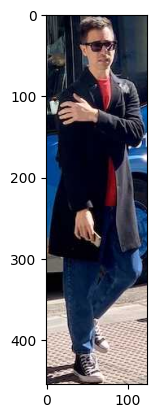

In [12]:
img_path = "https://ultralytics.com/images/bus.jpg"
res = requests.get(img_path)
img_arr = np.asarray(bytearray(res.content), dtype=np.uint8)
img_full = cv2.imdecode(img_arr, cv2.IMREAD_COLOR)
x1, y1, x2, y2 = boxes[3].astype(int)
img = img_full[y1:y2,x1:x2]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

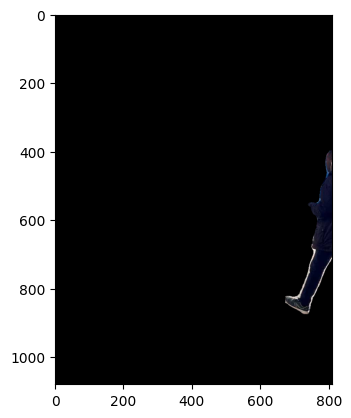

In [13]:
img_path = "https://ultralytics.com/images/bus.jpg"
response = requests.get(img_path)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
mask = results[0].masks.data[1].cpu().numpy()

mask = (mask * 255).astype(np.uint8)
masked_image = cv2.bitwise_and(image, image, mask=mask)
img = cv2.cvtColor(masked_image,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

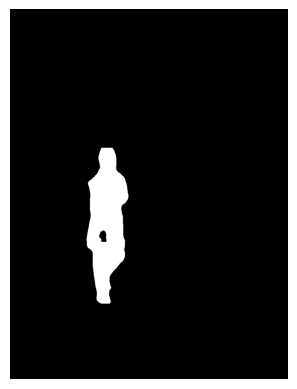

In [14]:
# Visualize the first mask from the results
if results[0].masks is not None:
	mask = results[0].masks.data[3].cpu().numpy()
	plt.imshow(mask, cmap='gray')
	plt.axis('off')
	plt.show()
else:
	print("No masks found in results.")

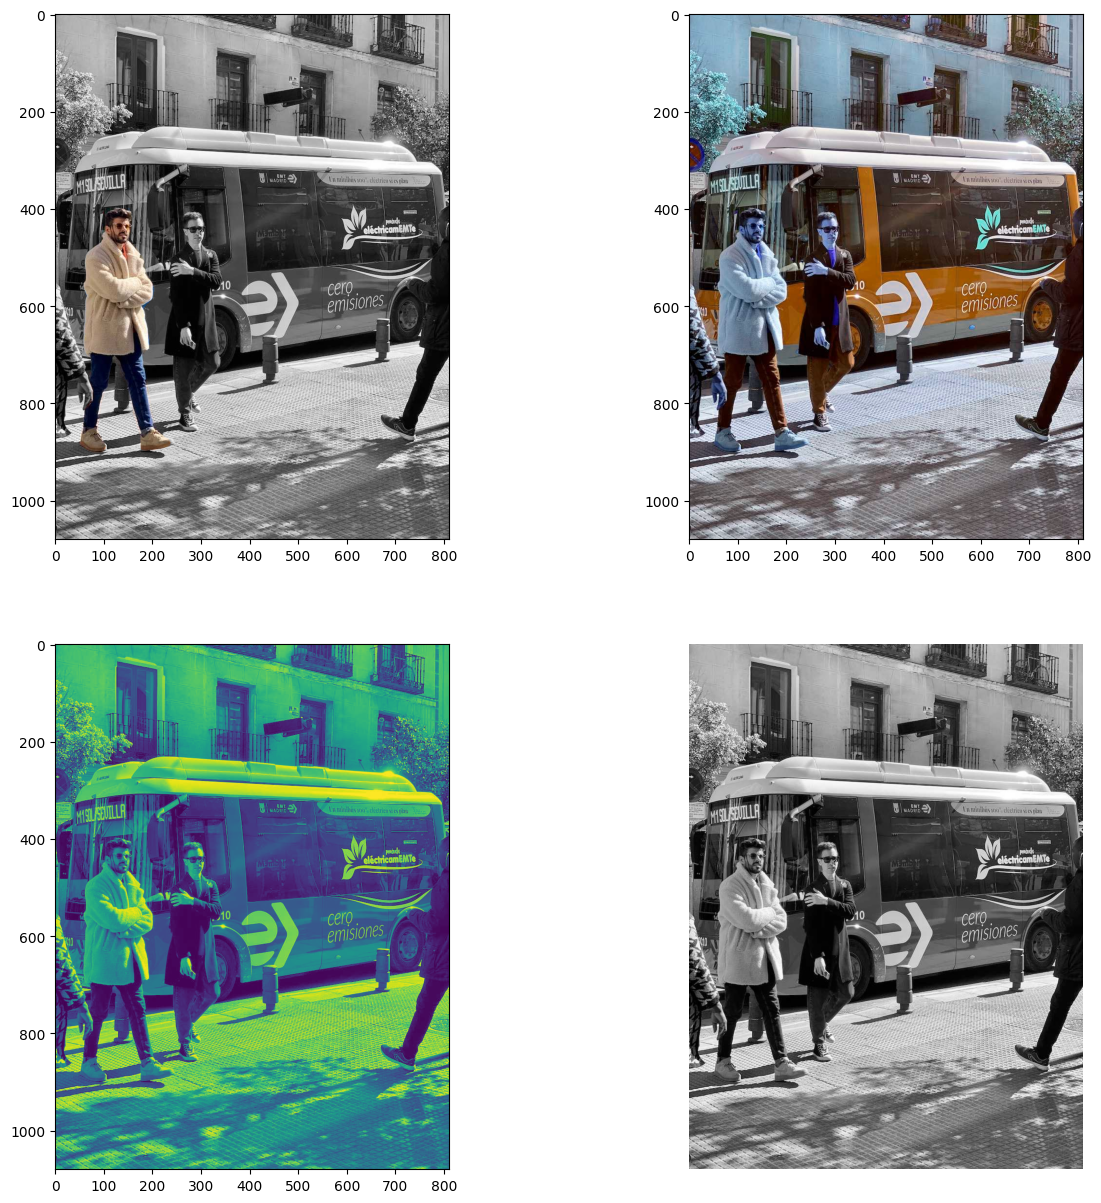

In [17]:
# 이미지 다운로드 및 디코딩
img_path = "https://ultralytics.com/images/bus.jpg"
response = requests.get(img_path)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# 마스크 가져오기
mask = results[0].masks.data[2].cpu().numpy()
mask = (mask * 255).astype(np.uint8)

# 원본을 흑백(그레이스케일)으로 변환
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 흑백 이미지를 다시 3채널로 변환 (컬러 유지 가능하도록)
gray_image_3ch = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

# 마스크 적용: 마스크 부분은 원본 컬러, 나머지는 흑백
masked_image = np.where(mask[:, :, None] > 0, image, gray_image_3ch)

# RGB 변환 및 출력
img = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(img)

plt.subplot(222)
plt.imshow(image)

plt.subplot(223)
plt.imshow(gray_image)

plt.subplot(224)
plt.imshow(gray_image_3ch)

plt.axis("off")
plt.show()

In [ ]:
import numpy as np
import cv2

# results[0].masks.data 는 (N, H, W) 형태로 여러 마스크를 가짐
# 여러 마스크를 누적 합산 (0,1) binary mask 로 만들기

num_masks = results[0].masks.data.shape[0]  # 마스크 개수
height, width = results[0].masks.data.shape[1], results[0].masks.data.shape[2]

# 누적 마스크 초기화 (bool 또는 uint8)
accum_mask = np.zeros((height, width), dtype=np.uint8)

for i in range(1):
    single_mask = results[0].masks.data[i].cpu().numpy()
    # 마스크를 0 또는 1로 임계 처리 (thresholding)
    binary_mask = (single_mask > 0).astype(np.uint8)
    accum_mask = np.maximum(accum_mask, binary_mask)  # 누적된 영역 확장

# 누적 마스크를 0~255로 스케일링
accum_mask = (accum_mask * 255).astype(np.uint8)

# 원본을 흑백으로 변환
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_image_3ch = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

# 누적 마스크를 이용해 컬러-흑백 합성 (마스크 > 0 영역은 컬러, 나머지는 흑백)
masked_image = np.where(accum_mask[:, :, None] > 0, image, gray_image_3ch)


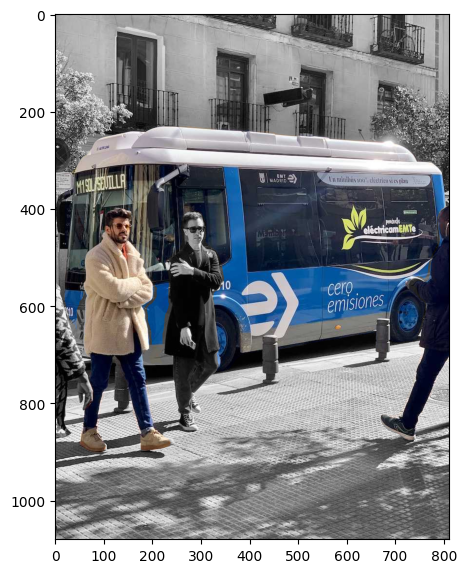

In [21]:
img = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(img)

(1080, 810)

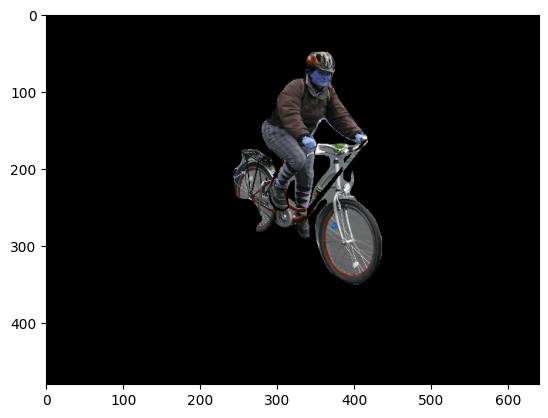

In [ ]:
# 좌표 문자열 (예시)
image = cv2.imread('./img/display/display_0a93b40a-84ba-4b61-a2e1-fc6d199cb5e1.jpg')
coords_str = ""
height,width = image.shape[:2]
point = [list(map(int,p.split(','))) for p in coords_str.split()]
pts = np.array(point,dtype=np.int32)
mask = np.zeros((height, width), dtype=np.uint8)
cv2.fillPoly(mask, [pts], 255)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_3ch = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
masked_image = np.where(mask[:, :, None] == 255, image, gray_3ch)
bitwise = cv2.bitwise_and(image,image,mask=mask)
plt.imshow(bitwise)